In [1]:
import torch
import numpy as np
import time
from PIL import Image
import skimage.segmentation
import skimage.color
import matplotlib.pyplot as plt
import maxflow

# Find fastest device available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Select backend for JIT compilation based on device (inductor is best but MPS only supports aot_eager)
jit_backend = "aot_eager" if device == "mps" else "inductor"

print("Using device:", device)
print("Using JIT backend:", jit_backend)

Using device: mps
Using JIT backend: aot_eager


In [2]:
# Define CNN module for GNEMS to use
class GNEMNet(torch.nn.Module):
    def __init__(self, image_size=(32,32), k=10, n_filters=16, dropout=0.2):
        super(GNEMNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, n_filters, 3, padding=1)
        self.BN1 = torch.nn.BatchNorm2d(n_filters)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(n_filters, 1, 3, padding=1)
        self.BN2 = torch.nn.BatchNorm2d(1)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.output = torch.nn.Linear(image_size[0] * image_size[1], k)
    
    # @torch.compile(backend=jit_backend)
    def forward(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = torch.flatten(x, 1)
        x = self.output(x)
        x = torch.sigmoid(x)
        return x

In [3]:
def tile(image, d):
    assert image.shape[0] % d == 0 or image.shape[1] % d == 0 # Image dimensions must be divisible by d
    tile_width = (image.shape[0] // d)
    tile_height = (image.shape[1] // d)
    image_tensor = torch.tensor(image, dtype=torch.float32)
    if len(image_tensor.shape) < 3:
        image_tensor = image_tensor.unsqueeze(2)
    tiles = image_tensor.unfold(0, tile_width, tile_height).unfold(1, tile_width, tile_height)
    tiles = tiles.permute(0, 1, 3, 4, 2)
    tiles = tiles.reshape(tiles.shape[0] * tiles.shape[1], tile_width, tile_height, tiles.shape[4])
    return tiles

def initial_labels(image, d, n_segments):
    seg = skimage.segmentation.slic(image, compactness=10, max_num_iter=10,
                                    n_segments=n_segments, start_label=0,
                                    enforce_connectivity=False, convert2lab=True)
    # while len(np.unique(seg)) > n_segments, merge smallest segments
    while len(np.unique(seg)) > n_segments:
        # count number of pixels in each segment
        segments, counts = np.unique(seg, return_counts=True)
        # find smallest segment
        smallest1 = segments[np.argmin(counts)]
        # find second smallest segment
        counts[smallest1] = np.max(counts)
        smallest2 = segments[np.argmin(counts)]
        # merge smallest segments
        seg[seg == smallest1] = smallest2

    t = torch.tensor(seg).unsqueeze(0).unsqueeze(0).float()
    labels = torch.nn.functional.interpolate(t, (d, d), mode="nearest")
    labels = labels.squeeze().to(torch.int64).reshape(d * d)
    labels = torch.nn.functional.one_hot(labels, n_segments).float()
    return labels

def graph_cut(probabilities, d, k, lambda_):
    D = probabilities.reshape(d, d, k)
    D = probabilities.astype(np.double)
    V = np.full((k, k), lambda_)
    labels = maxflow.abswap_grid(D, V)
    labels = labels.reshape(d**2).astype(np.int64)
    return labels

In [4]:
class GNEMS_Segmentor:
    def __init__(self, d=16, n_filters=16, dropout=0.2,
                lambda_=0.3, size=(512, 512), lr=0.001,
                iterations=100, subset_size=0.5,
                prediction_stride=1, slic_segments=100,
                sigma=3, seed=0, k=10):
        self.d = d
        self.n_filters = n_filters
        self.dropout = dropout
        self.lambda_ = lambda_
        self.size = size
        self.tile_size = (size[0] // d, size[1] // d)
        self.lr = lr
        self.iterations = iterations
        self.subset_size = subset_size
        self.prediction_stride = prediction_stride
        self.seed = seed
        self.net = None
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.slic_segments = slic_segments
        self.sigma = sigma
        self.k = k
        self.initial_labels = None

    def fit(self, image):
        self.losses = []
        self.intermediate_partitions = []
        self.intermediate_probabilities = []
        self.intermediate_graphs = []
        self.image = image

        assert image.shape[0] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[1] % self.d == 0 # image dimensions must be divisible by d
        assert image.shape[2] == 3 # image must channel last

        # Generate tiles and initial labels
        X = tile(image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        y_initial = initial_labels(image, self.d, self.k).to(device)
        self.initial_labels = y_initial

        # Initialize CNN
        self.net = GNEMNet(image_size=self.tile_size, n_filters=self.n_filters, dropout=self.dropout, k=self.k).to(device)
        
        # Initialize optimizer and loss function
        y_intermediate = y_initial.clone().detach()
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)

        # Train CNN
        itertimes = []
        graphtimes = []
        for iteration in range(self.iterations):
            start = time.time()

            # Extract subset of data
            shuffled_idx = torch.randperm(X.shape[0])
            X_shuffled = X[shuffled_idx]
            y_intermediate_shuffled = y_intermediate[shuffled_idx]
            X_subset = X_shuffled[:int(self.subset_size * X.shape[0])]
            y_intermediate_subset = y_intermediate_shuffled[:int(self.subset_size * X.shape[0])]

            # Perform network step
            inputs = X_subset
            labels = y_intermediate_subset
            optimizer.zero_grad()
            outputs = self.net(inputs)
            loss = criterion(outputs, labels)
            self.losses.append(loss.item() / X.shape[0])
            loss.backward()
            optimizer.step()

            # DEBUG WITHOUT GRAPH
            # Set pseudo-labels to network output rounded to nearest integer
            y_intermediate = torch.round(outputs).detach()

            # Skip graph step on last iteration
            if iteration != self.iterations - 1:
                # Perform graph step
                probabilities = self.net(X).detach().squeeze(1).cpu().numpy()
                self.intermediate_probabilities.append(probabilities)
                graph_start = time.time()
                partition = torch.tensor(graph_cut(probabilities, self.d, self.k, self.lambda_))
                partition = torch.nn.functional.one_hot(partition, self.k)
                self.intermediate_partitions.append(probabilities)
                graphtimes.append(time.time() - graph_start)

                # Update pseudo-labels
                y_intermediate = torch.Tensor(partition).type(torch.float32).to(device)

            itertimes.append(time.time() - start)

    def predict_low_res(self):
        X = tile(self.image, d=self.d).type(torch.float32).to(device).permute(0, 3, 1, 2)
        seg = self.net(X).detach().squeeze(1).reshape(self.d, self.d, self.k).cpu().numpy()
        return seg

    # def predict(self, show_progress=True):
    #     stride = self.prediction_stride
    #     image = self.image
    #     image_tensor = torch.tensor(image, dtype=torch.float32)
    #     all_tiles = image_tensor.unfold(0, self.tile_size[0], stride).unfold(1, self.tile_size[1], stride).reshape(-1, 1, self.tile_size[0], self.tile_size[1]).to(device)

    #     all_tiles_ds = TileDS(all_tiles)

    #     # set up dataloaders
    #     batch_size = 4096
    #     if device == "cuda":
    #         batch_size = 16384
    #     loader = torch.utils.data.DataLoader(all_tiles_ds, batch_size=batch_size, shuffle=False)
    #     n_batches = len(loader)

    #     with torch.no_grad():
    #         all_tiles_predictions = torch.zeros((len(all_tiles_ds))).to(device)
    #         iterator = tqdm(enumerate(loader), total=n_batches) if show_progress else enumerate(loader)
    #         for batch_i, batch in iterator:
    #             batch_predictions = self.net(batch)
    #             all_tiles_predictions[batch_i*loader.batch_size:(batch_i+1)*loader.batch_size] = batch_predictions.squeeze(1)

    #     predictions = all_tiles_predictions.reshape(((self.size[0] - self.tile_size[0]) // stride) + 1, ((self.size[1] - self.tile_size[1]) // stride) + 1)
    #     pixelwise_probabilities = torch.nn.functional.interpolate(predictions.unsqueeze(0).unsqueeze(0), size=image.shape, mode='bilinear', align_corners=True)
    #     pixelwise_probabilities -= pixelwise_probabilities.min()
    #     pixelwise_probabilities /= pixelwise_probabilities.max()
    #     pixelwise_probabilities *= 255
    #     pixelwise_probabilities = pixelwise_probabilities.squeeze(0).squeeze(0).cpu().numpy().astype(np.uint8)
    #     # return pixelwise_probabilities
    #     grayscale = False
    #     if 3 not in image.shape:
    #         grayscale = True
    #         image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    #     segments = slic(image, n_segments=self.slic_segments, sigma=self.sigma)
    #     segmentation = color.label2rgb(segments, pixelwise_probabilities, kind='avg', bg_label=0)
    #     segmentation = segmentation > auto_threshold(segmentation)
    #     if grayscale:
    #         segmentation = segmentation[:, :, 0]
    #     return segmentation

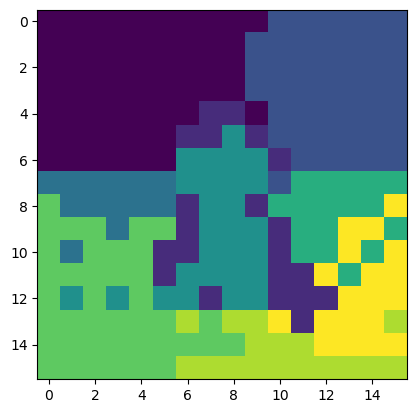

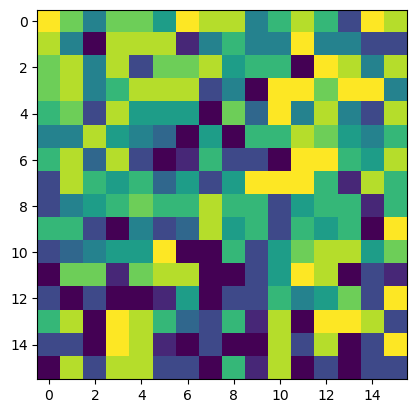

In [10]:
image = np.array(Image.open("tmp_images/dog.jpg").resize((512, 512)))

k = 10
d = 16
lambda_ = 0.15
segmentor = GNEMS_Segmentor(iterations=20, k=k, d=d, lambda_=lambda_)
segmentor.fit(image)
seg = segmentor.predict_low_res()
seg = np.argmax(seg, axis=2)
initial = segmentor.initial_labels.detach().cpu().numpy().reshape(segmentor.d, segmentor.d, segmentor.k).argmax(axis=2)

plt.imshow(initial)
plt.show()
plt.imshow(seg)
plt.show()

# plot all intermediate probabilities alongside intermediate partitions
# for i in range(len(segmentor.intermediate_probabilities)):
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.suptitle('Iteration {}'.format(i))
#     ax1.imshow(segmentor.intermediate_probabilities[i].reshape(d, d, k).argmax(axis=2))
#     ax2.imshow(segmentor.intermediate_partitions[i].reshape(d, d, k).argmax(axis=2))